In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Abstract Data Types

Nous commencons par créer une classe Sequence, qui est l'ADT qui représente une séquence d’acides aminés et toutes les opérations qu’on  peut  exécuter  sur  une  séquence (exemple:  retourner  un  acide  aminé  à  une  certaine  position ou visualiser la séquence en format FASTA).

In [2]:
class Sequence:
    def __init__(self, acids, annotation=None):
        self.acids = acids.upper()
        self.annotation = annotation
        
    def __getitem__(self, position):
        """ Renvoie l'acide aminé à la position donnée. Syntaxe: sequence[position] """
        return self.acids[position]
    
    def toFASTAFormat(self):
        return ">" + self.annotation + "\n" + self.acids
    
    def __repr__(self):
        return "Annotation: %s \nAcids: %s" % (self.annotation, self.acids)
    
    def length(self):
        return len(self.acids)
        

Nous créeons aussi une classe Score, qui est un ADT qui représente une matrice de substitution et les opérations qu'on peut exécuter sur cette matrice.

In [3]:
class Score:
    def __init__(self):
        self.letters = set()
        self.costs = {}
    
    def getNumLetters(self):
        return len(self.letters)
    
    def getLetters(self):
        return self.letters

    def getCost(self, a, b):
        return self.costs[(a, b)]
    
    def addCost(self, a, b, cost):
        self.letters.add(a)
        self.letters.add(b)
        self.costs[(a.upper(), b.upper())] = cost

## Parser

Nous devons créer des objets des classes Sequence et Score à partir des fichiers fournis. Il faut donc créer un parser pour les fichier des séquences (FASTA) et pour les fichiers avec les matrices de substitution (BLOSUM et PAM).

## FASTA

Les séquences d'acides aminés sont codées dans le format FASTA. Ce format est très simple.
Chaque séquence est encodée par une annotation et ensuite la liste d'acides aminés. Voici un exemple:

>&gt;sp|Q13526|PIN1_HUMAN Peptidyl-prolyl cis-trans isomerase NIMA-interacting 1 OS=Homo sapiens GN=PIN1 PE=1 SV=1
MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHL
LVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARG
DLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE

La prèmiere ligne (qui commence par >) est une annotation contenant des informations sur la séquence. Ensuite viennent une série de lignes contenant la séquence d'acides aminés (avec un maximum de 80 caractères par ligne, en général, pour faciliter la lisibilité). 

Un fichier FASTA est constitué d'une série de séquences formattées de cette façon.

In [4]:
def parseFASTASequencesFromFile(filename):
    with open(filename, 'r') as f:
        return parseFASTASequences(f)

def parseFASTASequences(lines):
    sequences = []
    annotation, acids = "", ""
    for line in lines:
        line = line.strip()

        justEndedPreviousSequence = (len(line) == 0 or line.startswith(">")) and acids != ""
        if justEndedPreviousSequence:
            sequences.append(Sequence(acids, annotation))

        if line.startswith(">"):
            annotation = line[1:]
            acids = ""
        else:
            acids += line.upper()

    return sequences


Appliquons ces parsers aux fichiers donnés:

In [5]:
sequencesFilenames = ['protein-sequences.fasta', 'WW-sequence.fasta']
proteinSequences, wwSequences = [parseFASTASequencesFromFile(filename) for filename in sequencesFilenames]

sequence = proteinSequences[0]

Faisons quelques tests pour vérifier notre fonction:

In [6]:
print("La première sequence est: \n")
print(sequence)

La première sequence est: 

Annotation: sp|P46937|YAP1_HUMAN Transcriptional coactivator YAP1 OS=Homo sapiens GN=YAP1 PE=1 SV=2 
Acids: MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGDSETDLEALFNAVMNPKTANVPQTVPMRLRKLPDSFFKPPEPKSHSRQASTDAGTAGALTPQHVRAHSSPASLQLGAVSPGTLTPTGVVSGPAATPTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNSNQQQQMRLQQLQMEKERLRLKQQELLRQAMRNINPSTANSPKCQELALRSQLPTLEQDGGTQNPVSSPGMSQELRTMTTNSSDPFLNSGTYHSRDESTDSGLSMSSYSVPRTPDDFLNSVDEMDTGDTINQSTLPSQQNRFPDYLEAIPGTNVDLGTLEGDGMNIEGEELMPSLQEALSSDILNDMESVLAATKLDKESFLTWL


In [7]:
print("\nLe premier acide aminé de la séquence est: " + sequence[0])


Le premier acide aminé de la séquence est: M


### Matrices de substitution

Les matrices de substitution sont aussi dans un format simple et intuitif. Le fichier commence par quelques lignes de commentaires (commencent par #) et puis est suivi de la grille des coûts de substitution.

Voici un exemple simplifié:

>```
# Ma matrice
# Il y 5 acides aminés dans cet exemple
   A  R  N  D  C
A  4 -1 -2 -2  0 -
R -1  5  0 -2 -3  
N -2  0  6  1 -3  
D -2 -2  1  6 -3  
C  0 -3 -3 -3  9 
```

In [8]:
def parseSubstitutionMatrixFromFile(filename):
    with open(filename, 'r') as f:
        return parseSubstitutionMatrix(f)

def parseSubstitutionMatrix(lines):
    score = Score()
    
    for line in lines:
        if line.startswith('#') or line.strip() == "": # Skip comments
            continue
        elif line.startswith('  '): # First line with letters
            letters = line.strip().upper().split()
        else:
            letterA, *costs = line.strip().upper().split()
            for (letterB, cost) in zip(letters, costs):
                score.addCost(letterA.upper(), letterB, int(cost))
    
    return score


Essayons d'appliquer ce parser à nos fichiers:

In [9]:
matricesFilenames = ['blosum62.txt', 'blosum80.txt', 'pam60.txt', 'pam120.txt']
blosum62, blosum80, pam60, pam120 = [parseSubstitutionMatrixFromFile(filename) for filename in matricesFilenames]

print("\nLe coût de subsition de R et C dans Blosum62 devrait être -3 et est %d" % blosum62.getCost('R', 'C'))
letters = blosum62.getLetters()
print("Il y a %d colonnes dans Blosum62: %s" % (len(letters), ''.join(sorted(letters))))


Le coût de subsition de R et C dans Blosum62 devrait être -3 et est -3
Il y a 24 colonnes dans Blosum62: *ABCDEFGHIKLMNPQRSTVWXYZ


# L'alignement de séquences

Une approche pour comparer des séquences d'acides (et donc des protéines) est d'examiner leur similarité en essayant de voir quelles séquences "s'alignent" le mieux. En d'autres mots, est-il facile de faire correspondre des acides aminés entre les 2 séquences? 

En quantifiant la difficulté d'alignement, on peut donc quantifier la similarité entre séquences d'acides aminés, et donc comparer un grande quantité de protéines entre elles de façon algorithmique.

# Alignement global 

L'alignement global cherche à trouver le meilleur alignement entre 2 séquences (d'acides aminés dans notre cas). Pour trouver l'alignement global optimal, nous allons implémenter l'algorithme de *Needleman-Wunsch* avec une penalité affine.

## L'algorithme de Needleman-Wunsch

Cet algorithme se base sur l'idée que trouver le meilleur alignement est un cas spécial du problème de la recherche de la distance d'édition entre les 2 séquences. On utilise donc une approche similaire pour résoudre les 2 problèmes.

### La distance d'édition

La distance d'édition est la séquencce d'insertions, de substitutions et d'effacements nécéssaires pour transformer un string A en un string B à un moindre coût.

Prennons par exemple les strings "ABCDAAA" et "BCEEAAA". Si chaque action (effacer, insérer, substituer) a un coût de 1, alors la meilleure distance d'édition est 3, car il faut:

1. Effacer le premier A
2. Remplacer le D par un E
3. Insérer un E avant le AAA


    ABCD-AAA
     ||. |||
    -BCEEAAA


Un espace en bas correspond à un effacement. Un espace en haut correspond à une insertion. Un point entre les lettres correspond à une substitution.

### Le lien avec l'alignement

Trouver le meilleur alignement correspond à trouver l'alignement qui minimise la distance d'édition. L'alignement est un cas spécial car actions différentes peuvent avoir des coûts différents. Par exemple:

- Effacer ou insérer un acide aminé a un coût 5
- Remplacer l'acide aminé R par C a un coût de 3
- Remplacer l'acide aminé W par V a un coût de 7
- Et ainsi de suite


On peut donc s'inspirer du concept de distance d'édition pour concevoir notre solution.

## Résume de l'algorithme

L'algorithme de Needleman-Wunsch est assez simple: 

1. On construit une matrice qui contient les distances d'éditions minimales entre des morceaux chaque fois plus grands des séquences, en mémorisant les actions faites pour aboutir à cette distance d'édition minimale
2. Une fois que la matrice est créée, on retrace les actions pour voir quel alignment minimise la distance d'édition et maximise la similarité
3. On crée l'alignement optimal à partir de cette suite d'actions

### Un exemple rapide

Le premier pas est de construire une *matrice des scores*. Les scores représentent la distance d'édition entre des parties des deux séquences. 

Soient les 2 séquences "ABCDAAA" et "BCEEAAA". Voici la matrice des score qu'on souhaite construire:

![Matrice des scores voulue](images/arrowfulSimpleMatrix.png)

**Comment interpreter cette matrice?**

Examinons par exemple la case $(2, 2)$. Ce score correspond au meilleur moyen de faire correspondre "AB" à "BC". Les actions à faire sont de descendre, d'aller en diagonale puis d'aller à droite. Ceci correspond à 

1. Éffacer A de la première séquence (en d'autres mots, le faire correspondre à un espace)
2. Faire correspondre B à B (en d'autres mots, substituer B par B)
3. Éffacer E de la deuxième séquènce (en d'autres mots, le faire corresponde à un espace)

On aboutit donc à l'alignement suivant:

    AB_
     |
    _BC

Comment interpréter les valeurs numériques des scores? Si le score est très bas, il faut beaucoup éditer, donc les séquences ne sont pas similaires. Si le score est élévé, le coût d'édition est bas et donc les séquences sont similaires.

**Par une approche similaire, on peut reconstruire le meilleur alignement en retraçant le meilleur chemin allant de la case du coin en bas à droite au coin en haut à gauche.**

### Étape 1: calculer la matrice des scores

Pour calculer la matrice des scores, on utilise une approche de programmation dynamique. Ainsi, pour arriver à une certaine case X, on a soit:

1. Fait correspondre la lettre précedente de la séquence 1 à un espace (on vient de la case du haut)
2. Fait correspondre la lettre précedente de la séquence 2 à un espace (on vient de la case de gauche)
3. Fait correspondre la lettre précedente de la séquence 1 avec la lettre précedente de la séquence 2 (on vient de la case en diagonale)

![Algorithme sans penalité affine](images/matrixSimple.png)

Pour chacune des trois possibilités, on prend le coût de la case précedente et on y ajoute le coût de la transformation vers la case courante. Pour cela, on doit connaître le coût de la correspondance entre 2 acides aminés (donné dans les matrices de substitution PAM et BLOSUM, par exemple) et celui entre un acide aminé et un espace.

Par exemple, on pourrait choisir une penalité constante de 4 et comme matrice de substitution BLOSUM62 (qui indique par exemple que le coût de substitution de l'acide aminé R par C est $-3$).

Le score final sera le maximum de ces 3 scores:

$$max(S(i - 1, j) + G, S(i, j - 1) + G, S(i - 1, j - 1) + coutRemplacement(i, j)$$

La première ligne et colonne de la matrice sont un cas spécial, car la formule précédente n'a pas de sens. En effet, il n'y a pas de voisin à gauche ou en diagonale pour la première colonne. Similairement, il n'y a pas de voisin en haut ou en diagonale pour la première ligne. Heureusement, ces 2 cas correspondent à une séquence d'espaces et on peut facilement réviser notre formule:

$$
S(i, j) = max \begin{cases} 
      i * G & si \, i \geq 0 \, et \, j = 0\\
      j * G & si \, i = 0 \, et \, j \geq 0\\
      max(S(i - 1, j) + G, S(i, j - 1) + G, S(i - 1, j - 1) + coutRemplacement(i, j) & ailleurs
\end{cases}
$$

## Penalité affine
Lorsque la penalité est affine, cela vaut dire que commencer une séquence d'espaces a un coût différent que de la prolonger. Par exemple, le 1er espace peut avoir un coût de 10 alors que les espaces qui le suivent n'ont qu'un coût de 2.

Pour calculer le score d'une case, il faut tester toutes les séquences d'espaces venant du haut et de la gauche (vu que le coût des espaces n'est plus linéaire) plutôt que juste tester le chemin via la case directement à gauche ou en haut.

![Algorithme global naif avec penalité affine](images/matrixComplex.png)

La façon la plus simple de calculer ce score est de calculer les scores venant de chacun des voisins (dont tous ceux à gauche et en haut) et de prendre le maximum. Malheureusement, cette approche augmente la complexité de l'algorithme parce qu'il peut il y avoir un grand nombre de voisins.

Si $n$ et $m$ sont les tailles des 2 séquences, avec $n > m$, alors la complexité de cette approche est $O(mn²)$, parce pour une case X, il y a approximativement $\frac{n}{2}$ voisins qui mennent à la case via des espaces et qu'il faut considérer pour calculer le score.

### Une meilleure approche

Il est possible de garder la complexité de $O(n * m)$. L'idée est simple. Soit $V(i, j)$ le meilleur score que l'on peut obtenir en arrivant à la case $(i, j)$ de la gauche. Comment peut-t-on le calculer?

Si on vient de la gauche pour aboutir à la case courante, alors on a soit:

**1. Commencé une séquence d'espaces à partir de la case directement à gauche**

>Dans ce cas, le score est très facile à calculer. C'est simplement le score de la case à gauche $(i - 1, j)$ + le coût de commencer une nouvelle séquence d'espaces: $S(i - 1, j) - I$.

**2. Continué une séquence d'espaces (qui a commencé avant la case directement à gauche)**

>Dans ce cas, on continue une séquence d'espaces. On sait que le coût pour paser de la case $(i - 1, j)$ à la case $(i, j)$ est de $E$, parce qu'on prolonge une séquence d'espaces. On sait aussi que la séquence d'espaces a commencé à gauche de $(i - 1, j)$. Il ne reste donc plus qu'à découvrir quel est le meilleur score que l'on peut obtenir en arrivant en $(i - 1, j)$  de la gauche.

>Heureusement, on connait ce coût! C'est $V(i - 1, j)$. 

>On en déduit que le meilleur score obtenu en prolongeant une séquence d'espaces est donc $V(i - 1, j) - E$.

#### Mettant le tout ensemble

Comme $V(i, j)$ est le meilleur score que l'on peut obtenir en arrivant de la gauche à la case $(i, j)$, il faut donc prendre le score maximum entre ces 2 posssibilités. On obtient donc l'expression suivante pour $V(i, j)$:

$$
V(i, j) = max \begin{cases} 
      S(i - 1, j) - I\\
      V(i - 1, j) - E
\end{cases}
$$

Par un raisonaiment similaire, on peut calculer $W(i, j)$, qui est le meilleur score que l'on peut obtenir en arrivant du haut à la case $(i, j)$

$$
W(i, j) = max \begin{cases} 
      S(i, j - 1) - I\\
      W(i, j - 1) - E
\end{cases}
$$

Avec toutes ces informations, il est donc facile de calculer $S(i, j)$. On peut y aboutir soit via une case à gauche, soit via une case en haut, soit via la case directement avant en diagonale. Le score gardé est le maximum de ces 3 possibilités.

$$
S(i, j) = max \begin{cases} 
      S(i - 1, j - 1) + coutCorrespondance(i, j)\\
      V(i, j)\\
      W(i, j)
\end{cases}
$$

L'image suivant illustre cette approche:

![Algorithme global avec penalité affine efficace](images/matrixTripleExplanation.png)

Si on utilise 2 matrices supplémentaires (V et W), on peut donc calculer la valeur de chaque case en $O(1)$, car il n'y a que 5 valeurs à calculer au maximum. Vu qu'il y a $n * m$ cases, cette approche permet donc d'avoir de nouveau une complexité de $O(n * m)$.

### Étape 2: calculer le meilleur chemin

Imaginons qu'on ait calculé la matrice des scores, ayant obtenu ceci:

![Exemple de matrice des scores](images/scoreMatrix.png)

Dans cette matrice, il y a des flèches entre des cases. Lorsqu'on calcule le score d'une cas, on prend le maximum des scores calculés via ses 3 voisins. Pour chaque voisin X qui permet d'obtenir ce score maximal, on ajoute une flèche entre X et Y. On retient donc quelle action (insérer, substituer, effacer) a mené à la case courante. 

On peut utiliser ces flèches pour trouver les chemin optimaux entre la dernière case et la première. Dans cet exemple, on peut voir que le meilleur chemin est la diagonale de la matrice. 

![Chemin trouvé dans l'exemple](images/pathFound.png)

Dans certains cas, il y a plusieures flèches entrant dans une cellule. Dans ce cas, il y a plusieurs chemins et donc plusieurs alignements globaux optimaux.

### Étape 3: recréer l'alignement à partir du chemin

Une fois qu'on a obtenu les chemins, il est très facile de recréer l'alignement optimal, car chaque deplacement a un sens précis:

1. Si on descend, on a fait correspondre l'acide aminé courant de la 1ere séquence avec un espace (action: effacer)
2. Si on va à droite, on a fait correspondre l'acide aminé courant de la 2eme séquence avec un espace (action: insérer)
3. Si on va en diagonale, on a fait correspondre l'acide aminé courant de la 1ere séquence avec l'acide aminé courant de la 2ème séquence (action: substituer)

Avec ces 3 règles, on peut facilement récréer l'alignement et donc d'obtenir un résultat comme ceci:

![Alignement de l'exemple](images/textAlignment.png)

In [10]:
def printMatrix(matrix):
    for line in matrix:
        print(line)

def makeMatrix(width, height, val=0):
    if type(val) in (int, str, bool):
        return [[val] * width for _ in range(height)]
    elif val == []:
        return [[[] for _ in range(width)]for _ in range(height)]
    else:
        return [[val for _ in range(width)]for _ in range(height)]

def getValue(matrix, x, y):
    if x < 0 or y < 0:
        return float('-inf')
    else:
        return matrix[y][x]

def getSolutionsFromArrowGridHelper(previous, k, x, y, isGlobal=True):
    completePaths = []
    incompletePaths = [[(x, y)]]
    numPaths = 1
    
    while len(incompletePaths) > 0 and len(completePaths) <= k:
        path = incompletePaths.pop()
        lastX, lastY = path[0]
            
        for (i, previousCoords) in enumerate(previous[lastY][lastX]):
            if i > 0: # 2+ paths from this cell
                numPaths += 1
                if numPaths > k: # No need to consider new paths if we already have enough
                    break
            
            # Ceci gère le cas où on fait de l'alignement local, que l'on décrit dans une section future)
            if not isGlobal and previousCoords is None:
                completePaths.append(path)
                continue
                
            newX, newY = previousCoords
            isComplete = (newX == 0 and newY == 0)
            
            if isComplete:
                completePaths.append([(newX, newY)] + path)
            else:
                incompletePaths.append([(newX, newY)] + path)

    return completePaths

def getSolutionsFromArrowGrid(previous, k, x=None, y=None, isGlobal=True):
    if x is None or y is None:
        x, y = len(previous[0]) - 1, len(previous) - 1
        
    return getSolutionsFromArrowGridHelper(previous, k, x, y, isGlobal)

def getPathScores(paths, s):
    pathScores = {}
    for path in paths:
        x, y = path[-1]
        pathScores[(x, y)] = s[y][x]
    
    return pathScores
            
def getBestGlobalAlignements(sequence1, sequence2, score, startGap=4, keepGap=1, k=1):
    """
    k: the maximum number of alignement returned (note: less than k alignements may be returned)
    """
    height, width = sequence1.length() + 1, sequence2.length() + 1
    v, w, s = [makeMatrix(width, height) for _ in range(3)]
    previous = makeMatrix(width, height, [])
    
    for i in range(1, width):
        s[0][i] = -(startGap + (i - 1) * keepGap)
        v[0][i] = float('-inf')
        previous[0][i] = [(i - 1, 0)]
    
    
    for i in range(1, height):
        s[i][0] = -(startGap + (i - 1) * keepGap)
        w[i][0] = float('-inf')
        previous[i][0] = [(0, i - 1)]
    
    for x in range(1, width):
        for y in range(1, height):
            v[y][x] = max(s[y - 1][x] - startGap, v[y - 1][x] - keepGap)
            w[y][x] = max(s[y][x - 1] - startGap, w[y][x - 1] - keepGap)
            replacementCost = score.getCost(sequence1[y - 1], sequence2[x - 1])

            coords = [(x, y - 1), (x - 1, y), (x - 1, y - 1)]
            costs = [v[y][x], w[y][x], s[y - 1][x - 1] + replacementCost]

            s[y][x] = bestScore = max(costs)
            previous[y][x] = []
            for coord, cost in zip(coords, costs):
                if cost == bestScore:
                    previous[y][x].append(coord)
                    
    score = s[height - 1][width - 1]
    paths = getSolutionsFromArrowGrid(previous, k)
    pathScores = getPathScores(paths, s)
    

    return s, paths, score, previous, pathScores

## Fonctions de visualisation

On définit quelques fonction pour visualiser les chemins et la matrice des scores, ce qui séra très utile pour
comprendre les actions de l'algorithme et les chemins créés.

In [11]:
from pprint import pprint
def showPath(path, matrix=None, seq1=None, seq2=None):
    x, y = path[-1]
    if matrix is None:
        height, width = x + 1, y + 1
    else:
        height, width = len(matrix), len(matrix[0])
    
    mat = makeMatrix(width, height)
    for x, y in path:
        mat[y][x] = 1
    
    plt.matshow(mat, cmap='Greys')
    
    # Axis Labels
    addSequenceLabelsToAxis(seq1, seq2, withNumbers=False)
    
    plt.show()

def addSequenceLabelsToAxis(seq1, seq2, withNumbers=True):
    def getLabels(acids):
        if withNumbers:
            return ['0'] + ['%s -  %d' % (acid.upper(), i) for (i, acid) in enumerate(acids, start=1)]
        else:
            return ' ' + acids
    
    if seq1 is not None:
        plt.yticks(range(seq1.length() + 1), getLabels(seq1.acids))
        
    if seq2 is not None:
        plt.xticks(range(seq2.length() + 1), getLabels(seq2.acids))

def printColoredMatrix(matrix, arrowMatrix=None, seq1=None, seq2=None, figsize=(8, 8), arrowColor='blue'):
    matrix = np.array(matrix)
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(matrix)

    # Values
    for (i, line) in enumerate(matrix):
        for (j, val) in enumerate(line):
            ax.text(j, i, str(val), va='center', ha='center')
    
    # Axis Labels
    addSequenceLabelsToAxis(seq1, seq2)
    
    # Arrows
    arrowprops = dict(facecolor=arrowColor, alpha=0.6, lw=0,
                  shrink=0.2, width=2, headwidth=7, headlength=7)
    
    if arrowMatrix is None:
        plt.show()
        return
    
    for (y, line) in enumerate(arrowMatrix):
        for (x, previousCells) in enumerate(line):
            for coords in previousCells:
                if coords is not None:
                    ax.annotate("", xy=coords, xytext=(x, y), arrowprops=arrowprops)
    
    plt.show()
 

## Alignement global: un exemple

Pour comprendre ce que fait l'algorithme, appliquons le à un exemple. On va aligner la séquence "writers" avec la séquence "vintner", voir l'alignement obtenu et visualiser la matrice de scores et le chemin.

The score matrix is



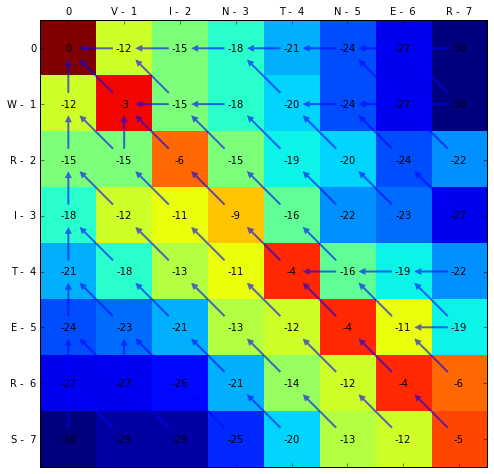

-5


In [12]:
a = Sequence('writers')
b = Sequence('vintner')

scoreMatrix, paths, score, arrowMatrix, pathScores = getBestGlobalAlignements(a, b, blosum62, startGap=12, keepGap=3, k=100)
print("The score matrix is\n")
printColoredMatrix(scoreMatrix, arrowMatrix, seq1=a, seq2=b)
print(score)

Number of paths found: 1



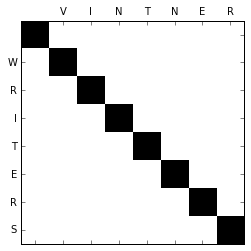

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]


In [13]:
print("Number of paths found: %d\n" % len(paths))
for path in paths:
    showPath(path, seq1=a, seq2=b)
    print(path)   

In [14]:
print("\nThe arrow matrix is\n")
printMatrix(arrowMatrix)


The arrow matrix is

[[], [(0, 0)], [(1, 0)], [(2, 0)], [(3, 0)], [(4, 0)], [(5, 0)], [(6, 0)]]
[[(0, 0)], [(0, 0)], [(1, 1), (1, 0)], [(2, 1)], [(3, 0)], [(4, 1)], [(5, 1), (5, 0)], [(6, 1), (6, 0)]]
[[(0, 1)], [(1, 1), (0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)], [(5, 1)], [(6, 1)]]
[[(0, 2)], [(0, 2)], [(1, 2)], [(2, 2)], [(3, 2)], [(4, 2)], [(5, 2)], [(6, 2)]]
[[(0, 3)], [(0, 3)], [(1, 3)], [(2, 3)], [(3, 3)], [(4, 4), (4, 3)], [(5, 4)], [(6, 4)]]
[[(0, 4)], [(0, 4)], [(1, 4)], [(2, 4)], [(3, 4)], [(4, 4)], [(5, 4)], [(6, 5), (6, 4)]]
[[(0, 5)], [(1, 5), (0, 5)], [(1, 5)], [(2, 5)], [(3, 5)], [(4, 5)], [(5, 5)], [(6, 5)]]
[[(0, 6)], [(0, 6)], [(1, 6)], [(2, 6)], [(3, 6)], [(4, 6)], [(5, 6)], [(6, 6)]]


# Retrouver les alignements

Une fois qu'on a fait retrouvé le chemin optimal, on peut créer l'alignement qui y correspond.

In [15]:
def printAlignments(path, sequence1, sequence2, subMatrix):
    text1, correspondance, text2 = "", "", ""
    firstCoord, *remainingCoords = path
    prevX, prevY = firstCoord
    
    for (i, (x, y)) in enumerate(remainingCoords):
        if x == prevX and y == prevY + 1: # Down
            text1 += sequence1[y - 1]
            text2 += "_"
            correspondance += " "
        elif x == prevX + 1 and y == prevY: # Right
            text1 += "_"
            text2 += sequence2[x - 1]
            correspondance += " "
        elif x == prevX + 1 and y == prevY + 1: # Diagonal
            text1 += sequence1[y - 1]
            text2 += sequence2[x - 1]
            
            letter1, letter2 = text1[-1], text2[-1]
            if letter1 == letter2:
                correspondance += "|"
            elif subMatrix.getCost(letter1, letter2) >= 3:
                correspondance += ":"
            elif subMatrix.getCost(letter1, letter2) > -2:
                correspondance += "."
            else:
                correspondance += " "
            
        prevX, prevY = x, y
        
        if i % 80 == 0 and i > 0:
            print('\n'.join([text1, correspondance, text2]))
            print()
            text1, correspondance, text2 = "", "", ""
    
    print('\n'.join([text1, correspondance, text2]))
    

def printAlignementResult(seq1, seq2, result, subMatrix, showScore = True, showLength = False):
    scoreMatrix, paths, score, arrowMatrix, pathScores = result
    if showScore:
        print("The best score is %d\n" % score)
        
    print(seq1, end="\n\n")
    print(seq2, end="\n\n")
    print("Alignements found: %d (may be artificially limited)\n" % len(paths))
    for (i, path) in enumerate(paths, start=1):
        if len(paths) > 0:
            print("Alignement number %d with score %d: \n" % (i, pathScores[path[-1]]))
            
        if showLength:
            print("The length of the alignement is %d" % len(path))
            
        startX, startY = path[0]
        endX, endY = path[-1]
        print("Sequence 1: %d-%d" % (startY + 1, endY))
        print("Sequence 2: %d-%d" % (startX + 1, endX))
               
        printAlignments(path, seq1, seq2, subMatrix)
        print()

Maintenant qu'on a définit la fonction, regardons l'alignement créé pour l'exemple.

In [16]:
def compareSequences(seq1, seq2, subMatrix=blosum62, startGap=4, keepGap=1, k=5, showScore=True):
    result = getBestGlobalAlignements(seq1, seq2, subMatrix, startGap, keepGap, k)
    scoreMatrix, score, previous, arrowMatrix, pathScores = result
    printAlignementResult(seq1, seq2, result,  subMatrix, showScore)
    #printColoredMatrix(scoreMatrix, arrowMatrix)

compareSequences(a, b, startGap=12, keepGap=3)

The best score is -5

Annotation: None 
Acids: WRITERS

Annotation: None 
Acids: VINTNER

Alignements found: 1 (may be artificially limited)

Alignement number 1 with score -5: 

Sequence 1: 1-7
Sequence 2: 1-7
WRITERS
   |...
VINTNER



Prenons des séquences réelles (présentes dans le fichier *ww-sequences.fasta*) et comparons-les.

In [17]:
ww1, ww2 = wwSequences[0], wwSequences[1]
compareSequences(ww1, ww2)

The best score is 77

Annotation: sp|P46937|171-204 
Acids: VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK

Annotation: sp|P46934|610-643 
Acids: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP

Alignements found: 1 (may be artificially limited)

Alignement number 1 with score 77: 

Sequence 1: 1-34
Sequence 2: 1-34
VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK
 |||.||| ...  |..|:.|| ...|.|. |..
SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP



On peut regarder quelle paires de séquences du fichier *ww-sequences.fasta* ont les meilleurs alignements.

In [18]:
import itertools

def getBestMatches(sequences):
    bestScore = float('-inf')
    bestResults = {}
    
    for seq1, seq2 in itertools.combinations(sequences, 2):
        scoreMatrix, paths, score, arrowMatrix, pathScores = result = getBestGlobalAlignements(seq1, seq2, blosum62, startGap=4, keepGap=1, k=5)
        if score > bestScore:
            bestScore = score
            bestResults = {(seq1, seq2): result}
        elif score == bestScore:
            bestResults[(seq1, seq2)] = result
    
    return bestResults, bestScore

# TODO: improve perfomance. Right now I'm computing the best path every time, 
# which is not needed except for the best sequences. Ideally this would be a lazy operation.
bestResults, score = getBestMatches(wwSequences)
print("The best matches have a score of %d" % score)
print("They are between these sequences: ")
i = 1
for (seq1, seq2), result in bestResults.items():
    print("\n------------- Sequences %d -----------------\n" % i)
    printAlignementResult(seq1, seq2, result, subMatrix=blosum62, showScore=False)
    i += 1

The best matches have a score of 117
They are between these sequences: 

------------- Sequences 1 -----------------

Annotation: sp|P46934|610-643 
Acids: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP

Annotation: sp|P46934|892-925 
Acids: GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL

Alignements found: 2 (may be artificially limited)

Alignement number 1 with score 117: 

Sequence 1: 1-34
Sequence 2: 1-34
SPLPPGWEER__QDILGRTYYVNHESRRTQWKRPTP
.|||||||||  .|  ||.:|:||. .||||. |. 
GPLPPGWEERTHTD__GRIFYINHNIKRTQWEDPRL

Alignement number 2 with score 117: 

Sequence 1: 1-34
Sequence 2: 1-34
SPLPPGWEER_Q_DILGRTYYVNHESRRTQWKRPTP
.||||||||| . |  ||.:|:||. .||||. |. 
GPLPPGWEERTHTD__GRIFYINHNIKRTQWEDPRL



## Comparaison avec LALIGN

Testons cette paire de séquences optimales avec [LALIGN](https://embnet.vital-it.ch/software/LALIGN_form.html), pour comparer le résultat obtenu:

Voici donc les information données par [LALIGN](https://embnet.vital-it.ch/software/LALIGN_form.html):

- **Score**: 115
- **Nombre d'acides aminés identiques dans l'alignement**: 55.6%
- **Nombre d'acides aminés similaires dans l'alignement**: 72.2%

On peut voir que le résultat est très proche. Le score obtenu est légèrement différent (115 plutôt que 117) et l'alignement aussi (seule la position du Q est différente dans le résulat de LALIGN).

**TODO: comprendre pourquoi le score et l'alignement est différent**

### Origine des séquences et Uniprot

Une question intéressante est "*Est-ce que ces 2 séquences viennent de la même protéine et quelles informations peut-t-on obtenir sur ces séquences?*"

Les 2 séquences ont comme annotations:

> sp|P46934|610-643 
 
et

> sp|P46934|892-925 

On peut donc directement voir qu'elles appartiennent à la même protéine, car elles ont le même identifiant: P46934. La première a comme position 610-643 et la deuxième la position 892-925 dans la protéine. Pour en savoir sur cette protéine, nous allons utiliser [Uniprot](http://www.uniprot.org/) pour les comparer.

![Information générale sur la protéine (global)](images/globalProteinInfo.png)

Plus bas, on peut accéder à l'information sur les domaines:

![Information sur les domaines de la protéine (global)](images/globalProteinDomains.png)


On peut donc voir que les 2 séquences correspondent au domaines *WW1* et *WW4* de la protéine. Vu que ces 2 séquences correspondent à un domaine du même type, il n'est donc pas étonnant qu'elles soient très similaires. 

Note: le domaine WW est assez connu en bioinformatique, ayant même [sa propre page Wikipedia](https://en.wikipedia.org/wiki/WW_domain).

# Alignement local

L'alignement global cherche le meilleur alignement entre 2 séquences. L'alignement local est plus général, parce qu'il cherche le meilleur alignement entre des parties des 2 séquences, qui peuvent être plus courtes que les séquences. Cela permet de trouver des *morceaux* de séquences qui sont très similaires.

La facon la plus naive de trouver le meilleur alignement local est d'appliquer l'algorithme d'alignement global à toutes les paires des *morceaux* des 2 séquences et de garder celles qui ont le meilleur score. Bien sûr, ceci est extrêmement peu efficace vu qu'il y a $2^{n + m}$ paires possibles. Il faut donc trouver une meilleure approche.

## L'algorithme de Smith Waterman

Imaginons qu'on appliqué l'alignement global, calculé la matrice des scores et obtenu un chemin donc les cases ont les scores suivants:

$$ [0, -2, -4, -5, -2, 1, 2, 5, 8, 10, 7, 6]$$

On peut remarquer plusieurs choses:

1. L'alignement qui se termine à la case de score 10 est meilleur que celui qui continue jusqu'au bout et a un score 6. Il faut donc s'arreter au maximum du chemin et ne pas garder les cases qui le suivent et font diminuer le score.

2. Certaines cases de cet alignement ont un score négatif. Si on ne éliminait ces acides aminés du chemin (et ceux qui le précedent, vu que le chemin doit être continu), alors le nouvel alignement ne pourrait être que meilleur, car il ne serait pas penalisé par ces acides aminés dissimilaires.

Ces idées ménent à l'algorithme de *Smith-Waterman*, qui est une variante de l'algorithme de *Needleman-Wunsch*. Voici les différences:

- On n'admet pas de scores négatifs. Si le score calculé est négatif, on le remplace par 0.
- Le retour en arrière (pour trouver le chemin) commence à partir de la case avec **le score maximum de toute la matrice** et on s'arrete dès qu'on trouve un 0.

Si un score est négatif, cela veut dire que les séquences jusqu'à cette position n'ont pas de similarités. Mieux vaut donc mettre le score à 0 pour éliminer l'influence de ce mauvais alignement, et ainsi permettre de trouver les alignement locaux qui commencent à partir de cette case. Ainsi, on ne pénalise pas les séquences qui commencent à une position interne, ce qui permet donc de trouver le meilleur alignement local.

L'algorithme est donc régi par cette nouvelle équation:

$$
S(i, j) = max \begin{cases} 
      S(i - 1, j - 1) + coutCorrespondance(i, j)\\
      V(i, j)\\
      W(i, j)\\
      0
\end{cases}
$$

**Corollaire:** la première colonne et ligne ont un score de 0, vu que des scores négatifs ne sont pas tolérés.

### Recherche du chemin et de l'alignement

La recherche du chemin (retour en arrière) commence à partir de la case avec le score maximum et s'arrete à la première case avec un score de 0.

Le création de l'alignment à partir du chemin ne change pas.

## Exemple

On reprend l'exemple antérieur avec les séquences "*writers*" et "*vintner*". Voici la matrice des scores qu'on obtient:

![Matrice des scores - alignement local](images/localAlignmentMatrix1.png)

Le maximum est la cellule en $(7, 6)$ avec score 11. On crée le chemin à partir de là, suivant les flèches jusqu'à arriver à une case avec un score de 0. On obtient ce chemin:

![Matrice avec le chemin - alignement local](images/localAlignmentPathMatrix.png)

Ceci correspond à l'alignement suivant

![Alignement - alignement local](images/localAlignmentText.png)

## Alignements sous-optimaux

Il se peut qu'on souhaite trouver les 5 meilleurs alignements locaux, mais qu'il n'y ait que 2 alignement locaux optimaux. Lorsqu'il n'y a pas assez d'alignements locaux optimaux, on recherche des alignements sous-optimaux. Mais comment les trouver?

Imaginons qu'on ait trouvé le chemin avec le score maximal, comme dans l'image suivante:

![Alignement local optimal](images/localBeforeZeroing.png)

Après avoir trouvé la séquence à score maximal, on met toutes ces cellules à 0 et on recalcule la matrice dans le voisinage du chemin optimal. Ceci a tendance à faire diminuer le score des chemins qui intersectent le chemin optimal qu'on vient de trouver. De cette façon, on peut trouver des alignements distincts qui peuvent avoir plus d'intêret, plutôt qu'un alignement qui partage un grand partie du chemin avec le chemin optimal.

![Alignements sous-optimaux](images/localAlignmentMatrixRecompute.png)

Le reste de l'algorithme ne change pas (création du chemin et de l'alignement). 

Si il faut trouver $n$ alignements, on trouve l'alignement local optimal puis on éxécute cette approche $n - 1$ fois pour trouver $n - 1$ alignements sous-optimaux.

### Calcul efficace

On peut recalculer la matrice des scores beaucoup plus efficacement, si on sait déduire quand est-ce que des cases ne seront pas affectées par le changement du chemin à 0.

Le [papier de Waterman-Eggert](https://dornsife.usc.edu/assets/sites/516/docs/papers/msw_papers/msw-079.pdf) nous donne les règles:

> Take the upper leftmost alignment position (i,j).

> For the single gap case, recompute each entry $(k,j)$, $k = i+l,i+2, ...$ until the new value $H^{*}_{k, j}$ equals the previous $H_{k,j}$. Then since $H^{*}_{l, j - 1} = H_{l, j-1}$, for all $l$, it is clear that $H^{*}_{l, j} = H_{j, j}$ for all $k < 1$. A similar calculation for the row $(i,k)$, $j < k$, allows us to stop whenever the new $H^{*}_{i, k}$ equals $H_{i, k}$.  We proceed by induction. We must go to at least the position that was necessary for the preceding row or column.

> To implement our algorithm for the linear gap case, the same procedure is followed as for the single gap case, except that here we stop along a row or column when all three quantities $H^{*}_{i,j}$, $E^{*}_{i, j}$ and $F^{*}_{i,j}$ are equal to $H_{i, j}$, $E_{i, j}$ and $F_{i, j}$, respectively.

En d'autres mots, on traite la matrice une ligne et colonne à la fois. On recalcule les valeurs de cette ligne/colonne tant que les nouvelles valeurs de S, V et W sont différentes. Si dans la ligne/colonne précédente on a recalculé X valuers, on doit aussi recalculer au moins X valeurs pour la ligne/colonne suivante. 

## Étape 1: sans alignements sous-optimaux

Nous allons d'abord commencer par implémenter une solution qui ne gère pas les alignements sous-optimaux. Dans la prochaine section, on s'occupera de mettre des valeurs à zéro, recalculer la matrice et trouver de nouveaux alignements (qui seront sous-optimaux).

Pour que cela ait un peu d'intêret, on trouve tous les alignements locaux optimaux (plutôt que juste le premier).

In [19]:
def findMaximumsInMatrix(matrix):
    maximum = []
    maxVal = float('-inf')
    for (y, line) in enumerate(matrix):
        for (x, value) in enumerate(line):
            if value > maxVal:
                maxVal = value
                maximums = [(x, y)]
            elif value == maxVal:
                maximums.append((x, y))
    return maximums

def findBestLocalPaths(s, previous, pathsToFind):
    bestCoords = findMaximumsInMatrix(s)
    x, y = bestCoords[0]
    score = s[y][x]
    
    
    if score == 0:
        return [], float('-inf')
    
    paths = []
    pathsLeft = pathsToFind
    for (x, y) in bestCoords:
        newPaths = getSolutionsFromArrowGrid(previous, pathsLeft, x, y, isGlobal=False)
        
        paths.extend(newPaths)
        pathsLeft -= len(newPaths)
        if pathsLeft <= 0:
            break
    
    
    return paths, score
    
def computeMatrix(s, v, w, sequence1, sequence2, previous, scoreSub, startGap, keepGap):
    height, width = sequence1.length() + 1, sequence2.length() + 1
    for x in range(1, width):
        for y in range(1, height):
            v[y][x] = max(s[y - 1][x] - startGap, v[y - 1][x] - keepGap)
            w[y][x] = max(s[y][x - 1] - startGap, w[y][x - 1] - keepGap)
            replacementCost = scoreSub.getCost(sequence1[y - 1], sequence2[x - 1])

            coords = [(x, y - 1), (x - 1, y), (x - 1, y - 1), None]
            costs = [v[y][x], w[y][x], s[y - 1][x - 1] + replacementCost, 0]

            s[y][x] = bestScore = max(costs)

            # Arrivé à un 0. Pas de flèches
            if bestScore == 0:
                previous[y][x] = [None]
                continue

            previous[y][x] = []
            for coord, cost in zip(coords, costs):
                if cost == bestScore:
                    previous[y][x].append(coord)

def getBestLocalAlignements(sequence1, sequence2, score, startGap=4, keepGap=1, l=1):
    """
    l: the maximum number of alignement returned (note: less than l alignements may be returned)
    """
    height, width = sequence1.length() + 1, sequence2.length() + 1
    v, w, s = [makeMatrix(width, height) for _ in range(3)]
    previous = makeMatrix(width, height, [])    
    
    pathsLeft = l
    computeMatrix(s, v, w, sequence1, sequence2, previous, score, startGap, keepGap)
    paths, bestScore = findBestLocalPaths(s, previous, pathsLeft)
    
    pathsLeft -= len(paths)
    pathScores = getPathScores(paths, s)
        
    return s, paths, bestScore, previous, pathScores

Observons les résultats de cette fonctions lorsqu'on utilise avec les séquences du premier exemple ("writers" et "vintner")

In [20]:
s1, s2 = a, b
result = getBestLocalAlignements(s1, s2, blosum62, startGap=4, keepGap=1, l=5)
printAlignementResult(s1, s2, result, blosum62, showScore = True, showLength = True)

scoreMatrix, paths, score, arrowMatrix, pathScores = result

The best score is 11

Annotation: None 
Acids: WRITERS

Annotation: None 
Acids: VINTNER

Alignements found: 1 (may be artificially limited)

Alignement number 1 with score 11: 

The length of the alignement is 5
Sequence 1: 4-6
Sequence 2: 4-7
T_ER
| ||
TNER



Visualisons la matrice des scores:

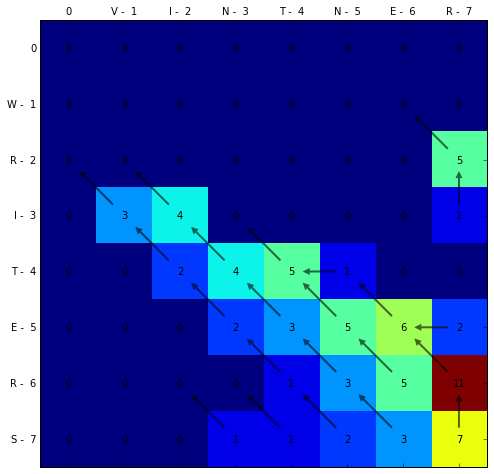

In [21]:
printColoredMatrix(scoreMatrix, arrowMatrix, seq1=a, seq2=b, figsize=(8, 8), arrowColor='black')

L'algorithm fonctionne correctement. On peut voir qu'il commence de la case avec score maximum (7, 6) et crée le chemin à partir de là. Visualisons ces chemins:

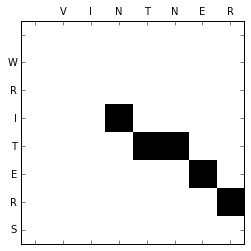

[(3, 3), (4, 4), (5, 4), (6, 5), (7, 6)]


In [22]:
for path in paths:
    showPath(path, scoreMatrix, seq1=a, seq2=b)
    print(path)

## Étape 2: avec alignements sous-optimaux



In [23]:
def findMatrixMaxPosAndScore(matrix):
    bestCoords = None
    maxVal = float('-inf')
    for (y, line) in enumerate(matrix):
        for (x, value) in enumerate(line):
            if value > maxVal:
                maxVal = value
                bestCoords = (x, y)
            
    return bestCoords, maxVal

def getBestLocalPath(s, previous):
    (x, y), score = findMatrixMaxPosAndScore(s)
    
    if score == 0:
        return None, float('-inf')
    else:    
        paths = getSolutionsFromArrowGrid(previous, 1, x, y, isGlobal=False)
        path = paths[0]
        return path, score

def getStartCoords(path, width, height):
    coords = []
    firstX, firstY = path[0]
    lastX, lastY = path[-1]
    
    size = min((width - 1) - firstX, (height - 1) - firstY) + 1
    for i in range(size):
        coords.append((firstX + i, firstY + i))
    
    
    # No coordinate should be equal to 0, because we shouldn't modify the first row or cols
    if firstX == 0 or firstY == 0:
        coords[0] = (max(1, firstX), max(1, firstY))
    
    return coords
    
def computeNewValue(x, y, sequence1, sequence2, s, v, w, previous, scoreSub, startGap, keepGap):
    v[y][x] = max(s[y - 1][x] - startGap, v[y - 1][x] - keepGap)
    w[y][x] = max(s[y][x - 1] - startGap, w[y][x - 1] - keepGap)
    replacementCost = scoreSub.getCost(sequence1[y - 1], sequence2[x - 1])

    coords = [(x, y - 1), (x - 1, y), (x - 1, y - 1), None]
    costs = [v[y][x], w[y][x], s[y - 1][x - 1] + replacementCost, 0 ]

    s[y][x] = bestScore = max(costs)

    # Arrivé à un 0. Pas de flèches
    if bestScore == 0:
        previous[y][x] = [None]
        return

    previous[y][x] = []
    for coord, cost in zip(coords, costs):
        if cost == bestScore:
            previous[y][x].append(coord)
    
def clearPathsAndRecomputeMatrix(s, v, w, sequence1, sequence2, path, scoreSub, previous, isInPath, startGap, keepGap):
    # Mettre les valeurs des chemins à 0
    for (x, y) in path:
        s[y][x] = 0
        v[y][x] = 0
        w[y][x] = 0
        previous[y][x] = [None]
        isInPath[y][x] = True
    
    height, width = len(s), len(s[0])
    
    prevMaxPosX, prevMaxPosY = float('-inf'), float('-inf')
    for (startX, startY) in getStartCoords(path, width, height):
        # Row
        for x in range(startX, width):
            if isInPath[startY][x]:
                continue
                
            oldV, oldW, oldS = v[startY][x], w[startY][x], s[startY][x]
            computeNewValue(x, startY, sequence1, sequence2, s, v, w, previous, scoreSub, startGap, keepGap)
            newV, newW, newS = v[startY][x], w[startY][x], s[startY][x]
            
            # Stop if new cells won't change
            if (oldV == newV and oldW == newW and oldS == newS) and x >= prevMaxPosX:
                break

            
        prevMaxPosX = x  
               
        # Column
        for y in range(startY + 1, height):
            if isInPath[y][startX]:
                continue
                
            oldV, oldW, oldS = v[y][startX], w[y][startX], s[y][startX]
            computeNewValue(startX, y, sequence1, sequence2, s, v, w, previous, scoreSub, startGap, keepGap)
            newV, newW, newS = v[y][startX], w[y][startX], s[y][startX]
            
            # Stop if new cells won't change
            if (oldV == newV and oldW == newW and oldS == newS) and y >= prevMaxPosY:
                break
        
        prevMaxPosY = y
        
def getAllBestLocalAlignements(sequence1, sequence2, scoreSub, startGap=4, keepGap=1, l=1, showMatrix=False):
    """
    l: the maximum number of alignement returned (note: less than l alignements may be returned)
    """
    height, width = sequence1.length() + 1, sequence2.length() + 1
    v, w, s = [makeMatrix(width, height) for _ in range(3)]
    previous = makeMatrix(width, height, [])   
    isInPath = makeMatrix(width, height, False)
    pathsLeft = l
    paths = []
    pathScores = {}
    
    for i in range(width):
        previous[0][i] = [None]
    
    for i in range(height):
        previous[i][0] = [None]
    
    # Find best paths
    computeMatrix(s, v, w, sequence1, sequence2, previous, scoreSub, startGap, keepGap)
    
    
    newPath, bestScore = getBestLocalPath(s, previous) 
    pathScores[newPath[-1]] = bestScore
    paths.append(newPath)
    pathsLeft -= 1
    
    if showMatrix:
        printColoredMatrix(s, previous, seq1=sequence1, seq2=sequence2)
    
    # If we don't find enough paths, keep searching for sub-optimal paths
    while pathsLeft > 0:
        clearPathsAndRecomputeMatrix(s, v, w, sequence1, sequence2, newPath, scoreSub, previous, isInPath, startGap, keepGap)
        
        if showMatrix:
            printColoredMatrix(s, previous, seq1=sequence1, seq2=sequence2)
        
        newPath, bestCurrentScore = getBestLocalPath(s, previous)  
        
        # No more good paths
        if newPath is None:
            print("Stopped searching because no good paths")
            break
        
        pathsLeft -= 1
        paths.append(newPath)
        pathScores[newPath[-1]] = bestCurrentScore
        
    return s, paths, bestScore, previous, pathScores
    
    

Appliquons cette fonction à notre premier exemple ("writers" et "vintner"). Pour mieux comprendre l'évolution de la matrice des scores, elle est aussi affichée chaque fois qu'elle est recalculée.

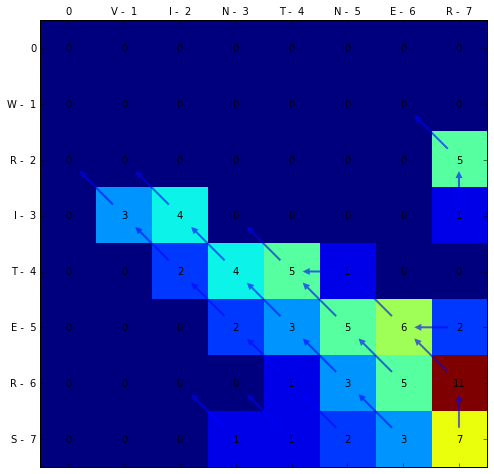

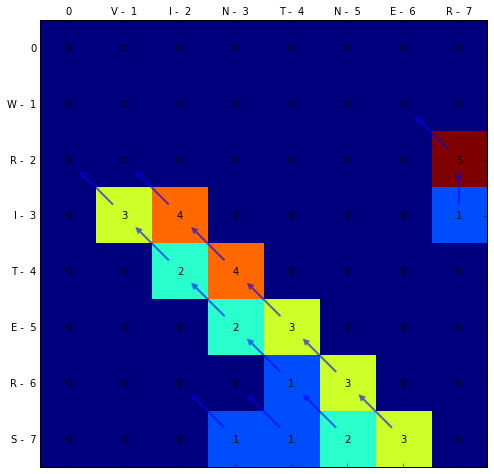

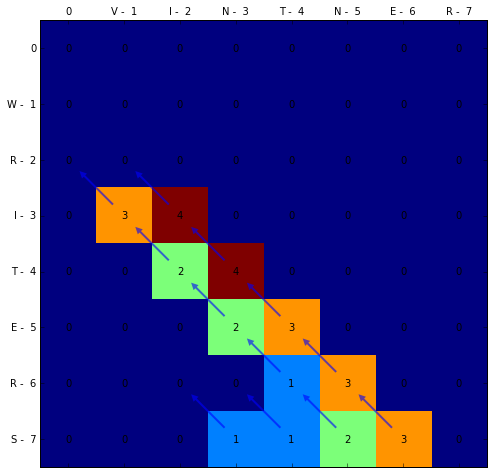

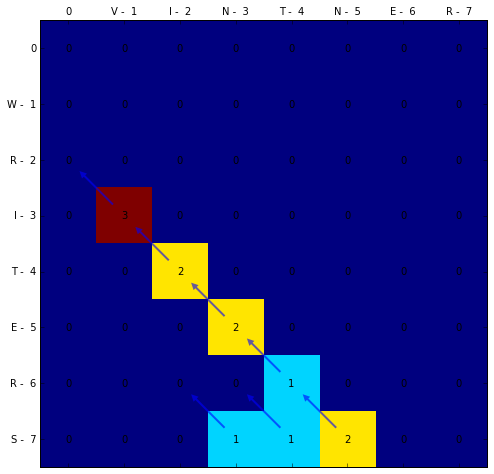

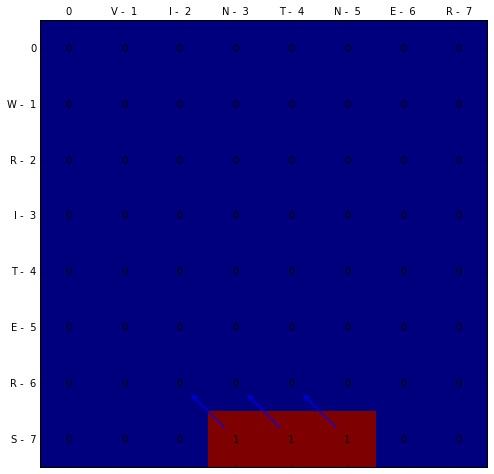

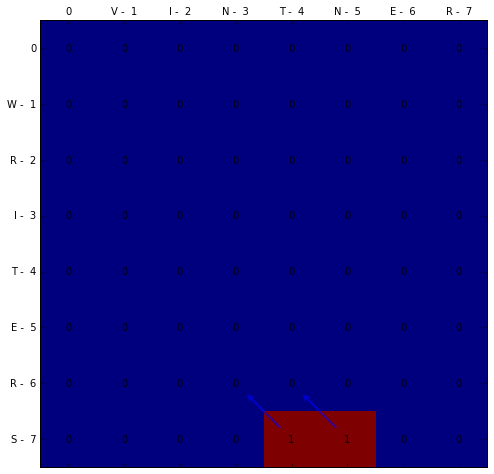

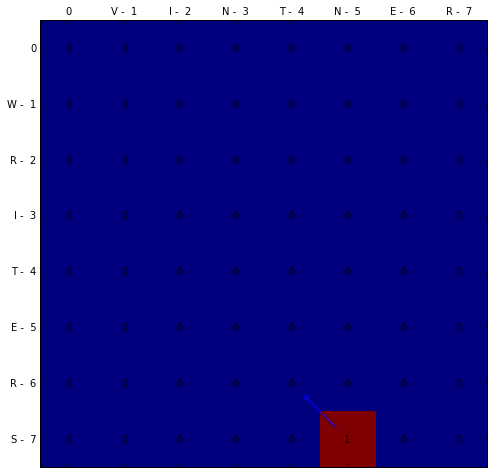

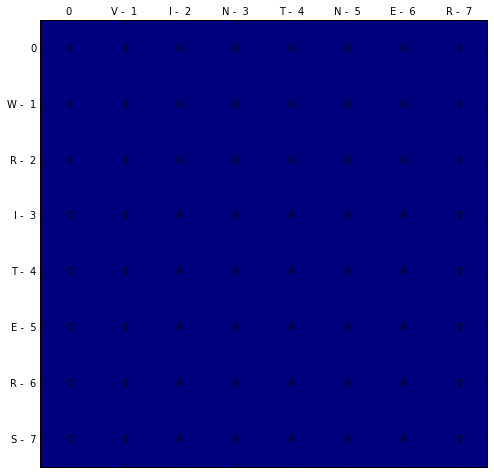

Stopped searching because no good paths
The best score is 11

Annotation: None 
Acids: WRITERS

Annotation: None 
Acids: VINTNER

Alignements found: 7 (may be artificially limited)

Alignement number 1 with score 11: 

Sequence 1: 4-6
Sequence 2: 4-7
T_ER
| ||
TNER

Alignement number 2 with score 5: 

Sequence 1: 2-2
Sequence 2: 7-7
R
|
R

Alignement number 3 with score 4: 

Sequence 1: 3-3
Sequence 2: 2-2
I
|
I

Alignement number 4 with score 3: 

Sequence 1: 3-3
Sequence 2: 1-1
I
:
V

Alignement number 5 with score 1: 

Sequence 1: 7-7
Sequence 2: 3-3
S
.
N

Alignement number 6 with score 1: 

Sequence 1: 7-7
Sequence 2: 4-4
S
.
T

Alignement number 7 with score 1: 

Sequence 1: 7-7
Sequence 2: 5-5
S
.
N



In [24]:
s1, s2 = a, b
#s1, s2 = ww1, ww2
result = getAllBestLocalAlignements(s1, s2, blosum62, startGap=4, keepGap=1, l=10, showMatrix=True)
printAlignementResult(s1, s2, result, blosum62, showScore = True, showLength = False)

scoreMatrix, paths, score, arrowMatrix, pathScores = result

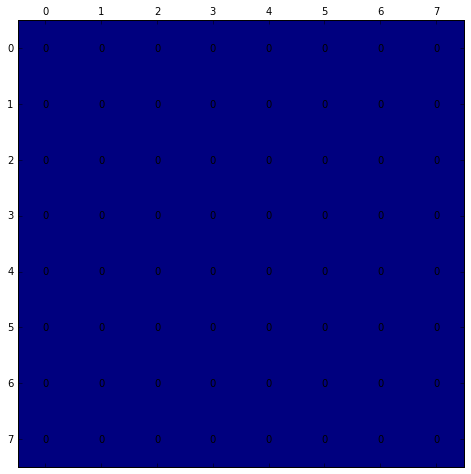

In [25]:
printColoredMatrix(scoreMatrix, arrowMatrix, figsize=(8, 8), arrowColor='black')

Visualisons les chemins créés:

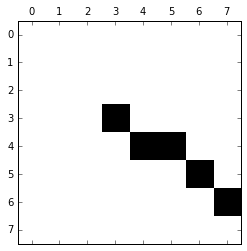

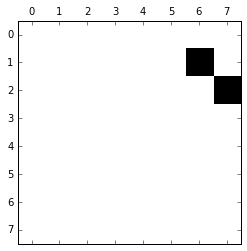

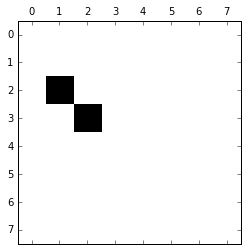

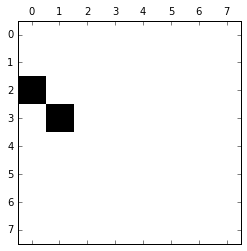

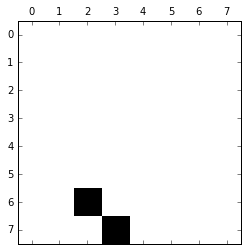

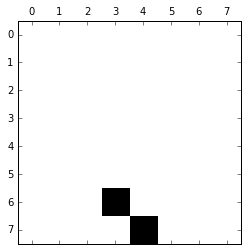

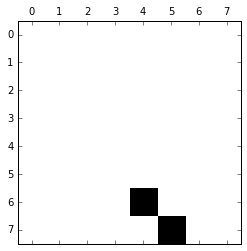

In [26]:
for path in paths:
    showPath(path, scoreMatrix)

Appliquons maintenant cet algorithme aux 2 premières séquences du fichier *protein-sequences.fasta*.

In [29]:
p1, p2 = proteinSequences[0], proteinSequences[1]
#p1, p2 = ww1, ww2
result = getAllBestLocalAlignements(p1, p2, blosum62, startGap=4, keepGap=1, l=2, showMatrix=False)
scoreMatrix, paths, score, arrowMatrix, pathScores = result
printAlignementResult(p1, p2, result, blosum62, showScore = True, showLength = True)

The best score is 435

Annotation: sp|P46937|YAP1_HUMAN Transcriptional coactivator YAP1 OS=Homo sapiens GN=YAP1 PE=1 SV=2 
Acids: MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGDSETDLEALFNAVMNPKTANVPQTVPMRLRKLPDSFFKPPEPKSHSRQASTDAGTAGALTPQHVRAHSSPASLQLGAVSPGTLTPTGVVSGPAATPTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNSNQQQQMRLQQLQMEKERLRLKQQELLRQAMRNINPSTANSPKCQELALRSQLPTLEQDGGTQNPVSSPGMSQELRTMTTNSSDPFLNSGTYHSRDESTDSGLSMSSYSVPRTPDDFLNSVDEMDTGDTINQSTLPSQQNRFPDYLEAIPGTNVDLGTLEGDGMNIEGEELMPSLQEALSSDILNDMESVLAATKLDKESFLTWL

Annotation: sp|P46934|NEDD4_HUMAN E3 ubiquitin-protein ligase NEDD4 OS=Homo sapiens GN=NEDD4 PE=1 SV=4 
Acids: MAQSLRLHFAARRSNTYPLSETSGDDLDSHVHMCFKRPTRISTSNVVQMKLTPRQTALAPLIKENVQSQERSSVPSSENVNKKSSCLQISLQPTRYSGYLQSSNVLADSDDASFTCILKDGIYSSAVVDNELNAVNDGHLVSSPAICSGSLSNFSTSDNGSYSSNGSDFGSCASITSGGSYTNSVISDSSSYTFPPSDDTFLGGNLPSDSTSNRSVPNRNTTPCEIFSRSTSTDPFVQDDLEHGLEIMKLPV

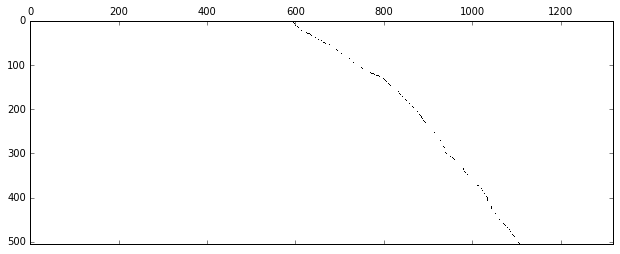

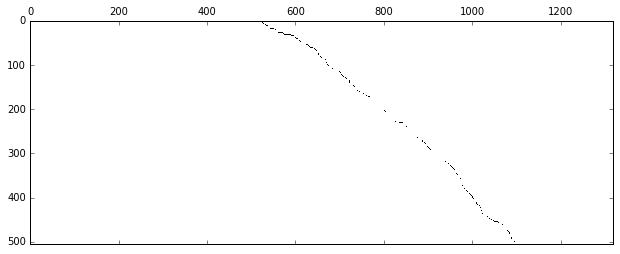

In [30]:
for path in paths:
    showPath(path, scoreMatrix)

# TODO TODO TODO


Comparez vos résultats avec l’outil LALIGN 1 . 
Utilisez les séquences du fichier protein-sequences.fasta et détectez quelles sont les 
parties similaires. Expliquez les similarités en utilisant les informations sur les protéines venant 
du site UniProt 2. 

# Notes d'implémentation

Pour des raisons de clarté, j'ai implementé le code via un série de fonctions. On peut rapidement voir que ceci n'est pas optimal, car certaines fonctions en appellent d'autres en leur passant beaucoup de paramètres. D'autre part, certaines fonctions sont des très proches variantes d'autres fonctions.

Ceci suggère que définir des classes (probablement avec de l'héritage) permettrait de simplifier le code et éviter des répétitions. Malheureusement, une classe doit être définie en une seule cellule Jupyter, et ce n'est donc pas possible d'intercaler du texte en Markdown et les définitions de méthodes de ces classes. Pour des raisons de clarté, je ne l'ai donc pas fait, mais dans du code réel je le ferai.